## Import Libraries

In [48]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

import seaborn as sns
import textwrap

from wordcloud import WordCloud, STOPWORDS

## Load Dataset

In [149]:
df = pd.read_csv('Amazon Sales Dataset.csv')

pd.set_option('display.max_colwidth', 20)  # Set the maximum column width to 20 characters
df.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Bra...,Computers&Access...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibili...,AG3D6O4STAQKAY2U...,"Manav,Adarsh gup...","R3HXWT0LRP0NMF,R...","Satisfied,Chargi...",Looks durable Ch...,https://m.media-...,https://www.amaz...
1,B098NS6PVG,Ambrane Unbreaka...,Computers&Access...,₹199,₹349,43%,4.0,"43,994",Compatible with ...,AECPFYFQVRUWC3KG...,"ArdKn,Nirbhay ku...","RGIQEG07R9HS2,R1...",A Good Braided C...,I ordered this c...,https://m.media-...,https://www.amaz...
2,B096MSW6CT,Sounce Fast Phon...,Computers&Access...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& ...,AGU3BBQ2V2DDAMOA...,"Kunal,Himanshu,v...","R3J3EQQ9TZI5ZJ,R...",Good speed for e...,Not quite durabl...,https://m.media-...,https://www.amaz...
3,B08HDJ86NZ,boAt Deuce USB 3...,Computers&Access...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce U...,AEWAZDZZJLQUYVOV...,"Omkar dhale,JD,H...","R3EEUZKKK9J36I,R...","Good product,Goo...","Good product,lon...",https://m.media-...,https://www.amaz...
4,B08CF3B7N1,Portronics Konne...,Computers&Access...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC F...,AE3Q6KSUK5P75D5H...,"rahuls6099,Swasa...","R1BP4L2HH9TFUP,R...",As good as origi...,Bought this inst...,https://m.media-...,https://www.amaz...


## Inspect the Dataset

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

In [5]:
# Check for missing values
df.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [6]:
# Check for duplicate rows
df.duplicated().sum()

0

## Data Preprocessing

### 1. Handle numerical columns

In [150]:
# Step 1: Convert price columns to numeric, handling commas and currency symbols
df['discounted_price'] = df['discounted_price'].replace({'₹': '', ',': ''}, regex=True).astype(float)
df['actual_price'] = df['actual_price'].replace({'₹': '', ',': ''}, regex=True).astype(float)

# Step 2: Convert 'discount_percentage' to float (remove % symbol)
df['discount_percentage'] = df['discount_percentage'].replace({'%': ''}, regex=True).astype(float)

# Step 3: Convert 'rating' to float
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')  # convert non-numeric values to NaN

# Step 4: Convert 'rating_count' to integer
df['rating_count'] = df['rating_count'].replace({',': ''}, regex=True).astype(float) # remove commas
df['rating_count'] = df['rating_count'].fillna(0).astype(int) # Fill NaN with zero and convert to integer

### 2. Handle categorical columns

In [151]:
# Step 1: Split the category column and take only first category
df['category'] = df['category'].str.split('|').str[0]
df['category'] = df['category'].str.replace('&', ' & ', regex=False)
df['category'] = df['category'].str.replace(r'([a-z])([A-Z])', r'\1 \2', regex=True)

# Step 2: Converts columns with strings like "A,B,C" into lists like ['A', 'B', 'C'], and returns NaN for non-string values
def clean_list_column(series):
    def clean_string(s):
        if isinstance(s, str):
            return s.split(',')
        return np.nan
    return series.apply(clean_string)

df['user_id'] = clean_list_column(df['user_id'])
df['user_name'] = clean_list_column(df['user_name'])
df['review_id'] = clean_list_column(df['review_id'])
df['review_title'] = clean_list_column(df['review_title'])
df['review_content'] = clean_list_column(df['review_content'])
df['img_link'] = clean_list_column(df['img_link'])

#### View the cleaned dataset

In [152]:
df.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Bra...,Computers & Acce...,399.0,1099.0,64.0,4.2,24269,High Compatibili...,[AG3D6O4STAQKAY2...,"[Manav, Adarsh g...","[R3HXWT0LRP0NMF,...","[Satisfied, Char...",[Looks durable C...,[https://m.media...,https://www.amaz...
1,B098NS6PVG,Ambrane Unbreaka...,Computers & Acce...,199.0,349.0,43.0,4.0,43994,Compatible with ...,[AECPFYFQVRUWC3K...,"[ArdKn, Nirbhay ...","[RGIQEG07R9HS2, ...",[A Good Braided ...,[I ordered this ...,[https://m.media...,https://www.amaz...
2,B096MSW6CT,Sounce Fast Phon...,Computers & Acce...,199.0,1899.0,90.0,3.9,7928,【 Fast Charger& ...,[AGU3BBQ2V2DDAMO...,"[Kunal, Himanshu...","[R3J3EQQ9TZI5ZJ,...",[Good speed for ...,[Not quite durab...,[https://m.media...,https://www.amaz...
3,B08HDJ86NZ,boAt Deuce USB 3...,Computers & Acce...,329.0,699.0,53.0,4.2,94363,The boAt Deuce U...,[AEWAZDZZJLQUYVO...,"[Omkar dhale, JD...","[R3EEUZKKK9J36I,...","[Good product, G...","[Good product, l...",[https://m.media...,https://www.amaz...
4,B08CF3B7N1,Portronics Konne...,Computers & Acce...,154.0,399.0,61.0,4.2,16905,[CHARGE & SYNC F...,[AE3Q6KSUK5P75D5...,"[rahuls6099, Swa...","[R1BP4L2HH9TFUP,...",[As good as orig...,[Bought this ins...,[https://m.media...,https://www.amaz...


# 📈 Exploratory Data Analysis 📈

In [10]:
# Descriptive statistics for numerical columns
df.describe().round(2)

,discounted_price,actual_price,discount_percentage,rating,rating_count
count,1465.00,1465.00,1465.00,1464.00,1465.00
mean,3125.31,5444.99,47.69,4.10,18270.56
std,6944.30,10874.83,21.64,0.29,42730.00
min,39.00,39.00,0.00,2.00,0.00
25%,325.00,800.00,32.00,4.00,1173.00
50%,799.00,1650.00,50.00,4.10,5178.00
75%,1999.00,4295.00,63.00,4.30,17325.00
max,77990.00,139900.00,94.00,5.00,426973.00


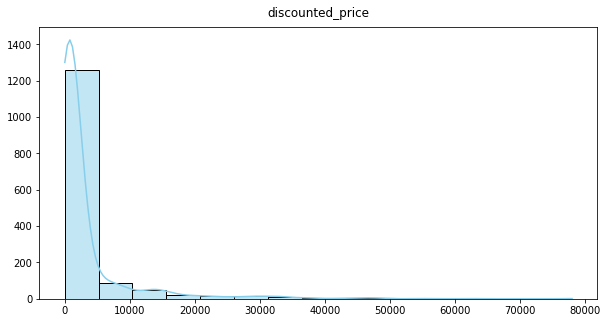

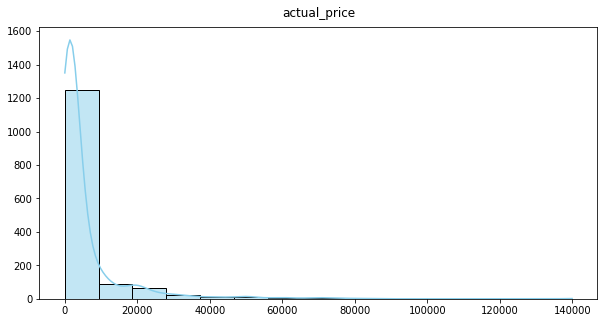

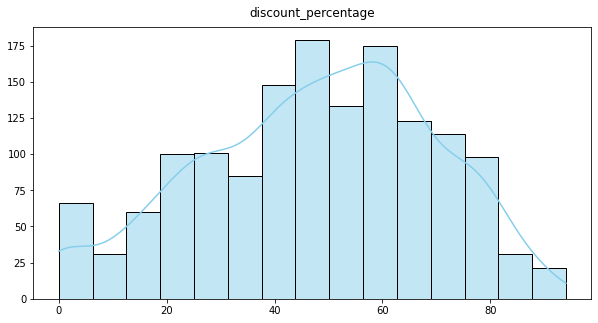

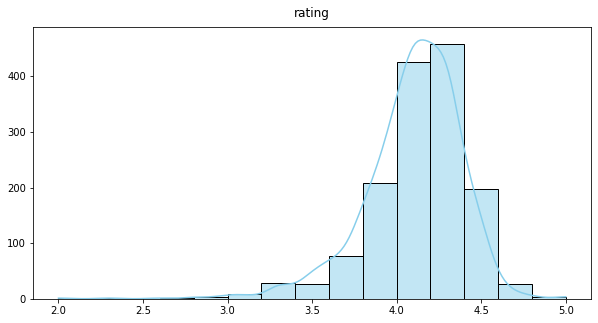

In [34]:
# Histograms for numerical columns
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 5))       
    sns.histplot(df[column], kde=True, bins=15, color='skyblue')
    
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'{column}', pad = 10)
    
    plt.show()

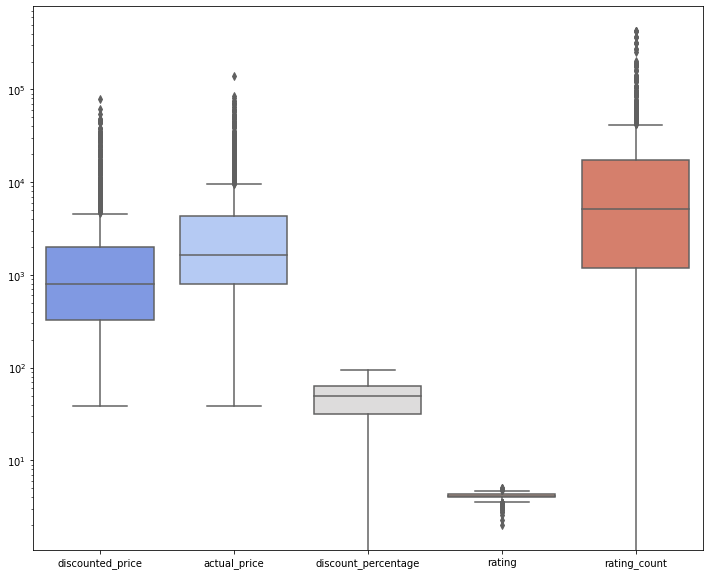

In [40]:
# Boxplot for checking outliers
plt.figure(figsize=(12, 10))
sns.boxplot(data=df, palette = "coolwarm")
plt.yscale('log')

plt.show()

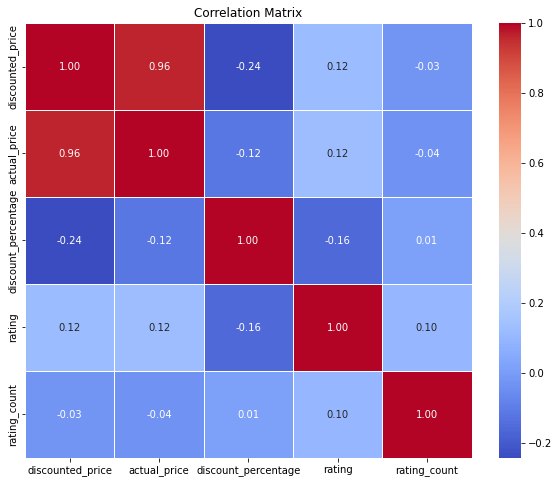

In [15]:
# Correlation matrix to detect relationships between numerical columns
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

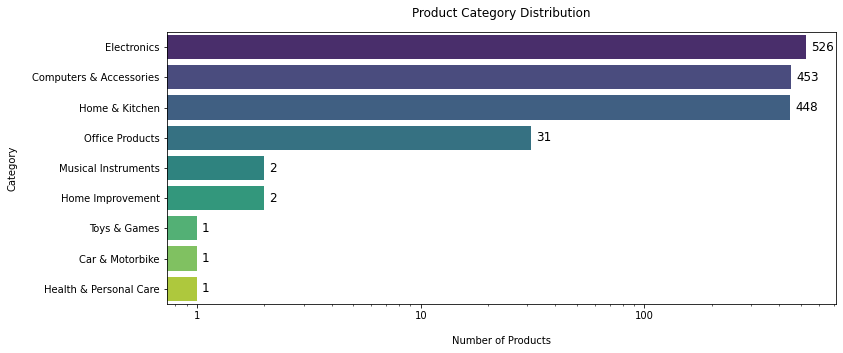

In [113]:
# List of unique product categories and their distribution
category_counts = df['category'].value_counts()

plt.figure(figsize=(12, 5))
ax = sns.barplot(y=category_counts.index, x=category_counts.values, palette='viridis')

plt.title("Product Category Distribution", pad = 15)
plt.xlabel("Number of Products", labelpad = 15)
plt.ylabel("Category", labelpad = 15)

# Add labels on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                fontsize=12, color='black', 
                xytext=(5, 0), 
                textcoords='offset points')

# Apply log scale to the x-axis
plt.xscale('log')
def format_func(value, tick_number):
    return f'{int(value)}'

ax.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

In [17]:
# Number of unique users
unique_user_ids = df['user_id'].explode().dropna().unique()
num_unique_users = len(unique_user_ids)

print(f"Number of unique users: {num_unique_users}")

Number of unique users: 9050


# 📊 Product Performance Analysis 📊

## Top Products by Average Rating

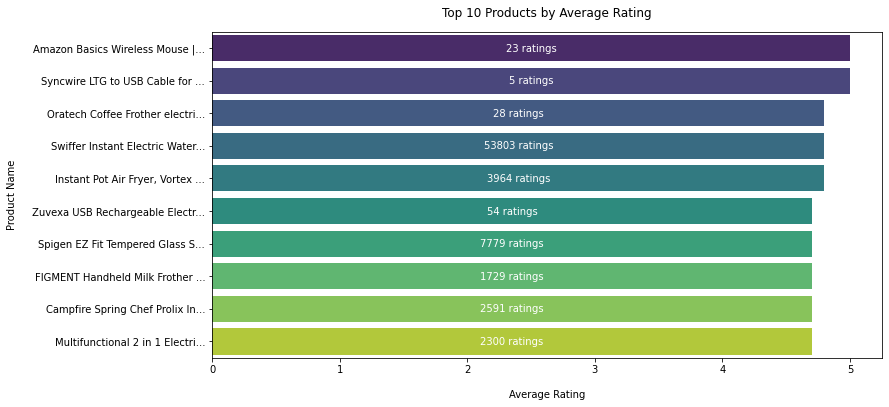

In [186]:
# Calculate average rating and total rating_count per product
top_rated_products = df.groupby('product_name').agg(
    avg_rating=('rating', 'mean'),
    total_reviews=('rating_count', 'sum')  # Sum the rating_count to get total reviews
).reset_index()

# Filter out products with 0 total_reviews
top_rated_products = top_rated_products[top_rated_products['total_reviews'] > 0]

# Shorten product names
max_length = 30
top_rated_products['short_product_name'] = top_rated_products['product_name'].apply(lambda x: x[:max_length] + '...' if len(x) > max_length else x)

# Sort by average rating in descending order and select top 10
top_rated_products = top_rated_products.sort_values(by='avg_rating', ascending=False)
top_n_products = top_rated_products.head(10)

# Plot the chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='avg_rating', y='short_product_name', data=top_n_products, palette='viridis')

# Add the total number of ratings as text labels inside the bars
for i, (index, row) in enumerate(top_n_products.iterrows()):
    if i < len(ax.patches):
        bar_width = ax.patches[i].get_width()
        bar_x_position = ax.patches[i].get_x() 
        
        # Place the text at the center of the bar
        ax.text(
            bar_x_position + bar_width / 2,
            i,
            f'{int(row["total_reviews"])} ratings',  # Total number of reviews as text
            va='center',  
            ha='center',  
            fontsize=10, 
            color='white'  
        )

# Title and labels
plt.title('Top 10 Products by Average Rating', pad=15)
plt.xlabel('Average Rating', labelpad=15)
plt.ylabel('Product Name', labelpad=15)

plt.show()

## Top Products by Number of Ratings

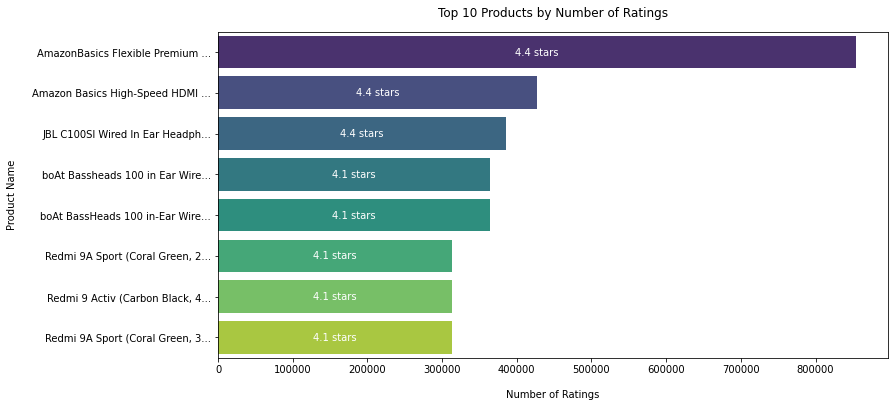

In [185]:
# Count the number of reviews per product
top_products_by_review_count = df.groupby('product_name').agg(
    rating_count=('rating_count', 'sum'),  # Summing 'rating_count' to get the total reviews
    avg_rating=('rating', 'mean')  # Calculating the average rating for each product
).reset_index()

# Sort by review count in descending order and select top 10
top_products_by_review_count = top_products_by_review_count.sort_values(by='rating_count', ascending=False)
top_n_products_by_review_count = top_products_by_review_count.head(10).copy()

# Shorten product names
max_length = 30
top_n_products_by_review_count.loc[:, 'short_product_name'] = top_n_products_by_review_count['product_name'].apply(lambda x: x[:max_length] + '...' if len(x) > max_length else x)

# Plot the chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='rating_count', y='short_product_name', data=top_n_products_by_review_count, palette='viridis')

# Add the average rating as text labels inside the bars
for i, (index, row) in enumerate(top_n_products_by_review_count.iterrows()):
    if i < len(ax.patches):
        bar_width = ax.patches[i].get_width()
        bar_x_position = ax.patches[i].get_x()
        
        ax.text(
            bar_x_position + bar_width / 2,
            i,
            f'{row["avg_rating"]:.1f} stars',  # Format the text as 'avg_rating avg'
            va='center',
            ha='center',
            fontsize=10,
            color='white'
        )

plt.title('Top 10 Products by Number of Ratings', pad=15)
plt.xlabel('Number of Ratings', labelpad=15)
plt.ylabel('Product Name', labelpad=15)

plt.show()

## Rating vs. Price

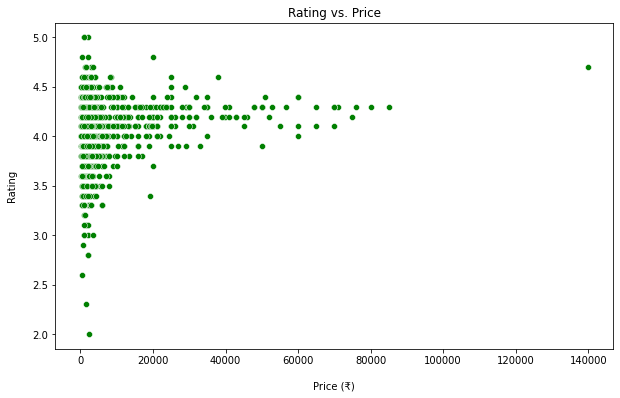

In [137]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='actual_price', y='rating', data=df, color='green')
plt.title('Rating vs. Price')
plt.xlabel('Price (₹)', labelpad = 15)
plt.ylabel('Rating', labelpad = 15)
plt.show()

## Distribution of Products by Rating Category

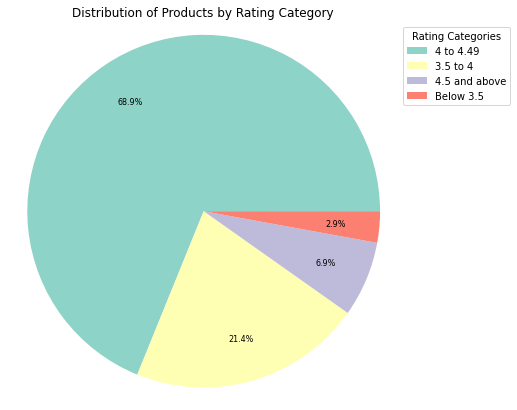

In [174]:
# Define rating categories based on rating values
bins = [0, 3.5, 4.0, 4.5, 5.0]
labels = ['Below 3.5', '3.5 to 4', '4 to 4.49', '4.5 and above']

df['rating_category'] = pd.cut(df['rating'], bins=bins, labels=labels, right=False)
rating_category_counts = df['rating_category'].value_counts()

# Plot the pie chart
palette = sns.color_palette("Set3", n_colors=4)

plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(
    rating_category_counts, 
    autopct='%1.1f%%', 
    colors=palette, 
    startangle=0, 
    labeldistance=1.2,  # Move labels outside of the pie chart
    pctdistance=0.75,   # Move percentage labels closer to the center
    textprops={'fontsize': 8}
)

plt.legend(wedges, rating_category_counts.index, title="Rating Categories", loc="upper left", bbox_to_anchor=(1, 1))

plt.title('Distribution of Products by Rating Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## World Cloud

### 1. Most frequent words in Product Reviews

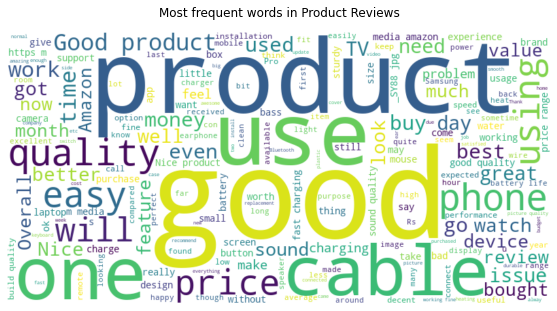

In [96]:
# Combine all review content into a single string, handling missing values
text = " ".join(df['review_content'].dropna().apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)))

# Generate word cloud with stopwords removed ('the', 'and', etc.)
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color="white", 
    stopwords=STOPWORDS
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most frequent words in Product Reviews", pad = 15)
plt.show()

### 2. Most common Words in Product Descriptions

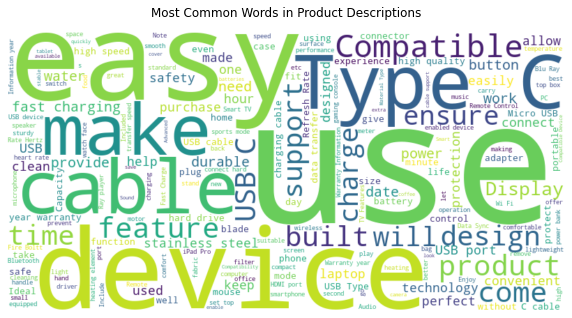

In [131]:
text = " ".join(df['about_product'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Product Descriptions", pad=15)
plt.show()

## Discounted vs Non-Discounted Products

### 1. Count of Products per Discounted vs Non-Discounted

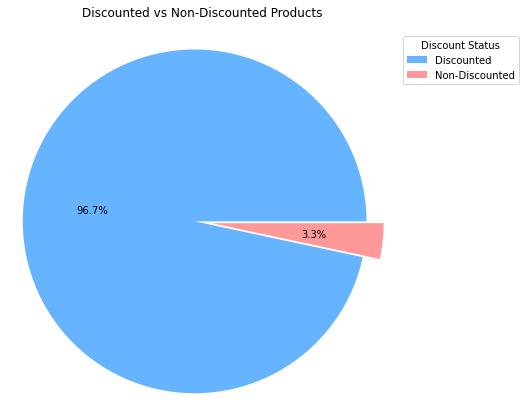

In [183]:
discount_status_count = df['Discount Status'].value_counts()

# Plot the pie chart
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(
    discount_status_count,
    autopct='%1.1f%%',
    colors=['#66b3ff', '#ff9999'],
    startangle=0,
    explode=(0.1, 0),
    labels=None
)

plt.legend(wedges, discount_status_count.index, title="Discount Status", loc="upper left", fontsize=10, bbox_to_anchor=(1, 1))

plt.title('Discounted vs Non-Discounted Products', pad=15)
plt.axis('equal')

plt.show()


### 2. Average Rating Comparison

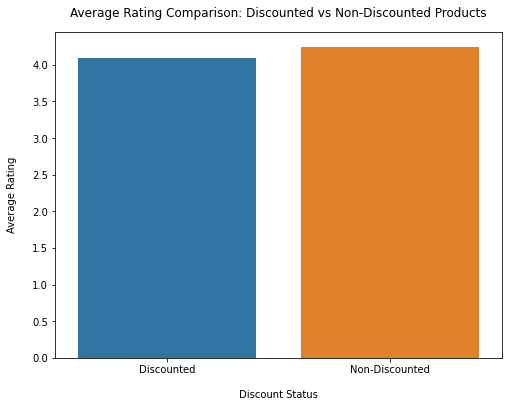

In [162]:
df['Discount Status'] = df['discount_percentage'].apply(lambda x: 'Discounted' if x > 0 else 'Non-Discounted')
avg_rating_by_discount = df.groupby('Discount Status')['rating'].mean().reset_index()

# Plot the chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Discount Status', y='rating', data=avg_rating_by_discount)

plt.title('Average Rating Comparison: Discounted vs Non-Discounted Products', pad = 15)
plt.xlabel('Discount Status', labelpad = 15)
plt.ylabel('Average Rating', labelpad = 15)

plt.show()

### 3. Number of Ratings Comparision

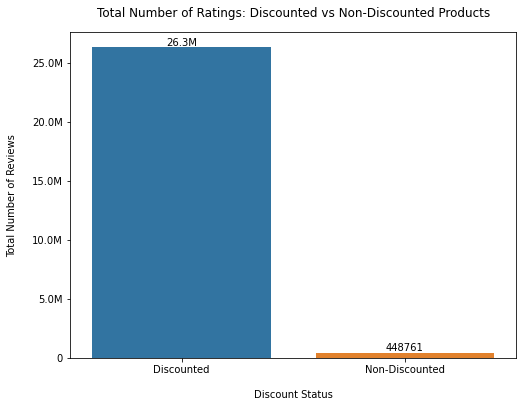

In [169]:
total_reviews_by_discount = df.groupby('Discount Status')['rating_count'].sum().reset_index()

# Plot the chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Discount Status', y='rating_count', data=total_reviews_by_discount)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M' if x >= 1_000_000 else f'{x:.0f}'))

for i in ax.patches:
    rating_count = i.get_height()
    formatted_label = f'{rating_count * 1e-6:.1f}M' if rating_count >= 1_000_000 else f'{int(rating_count)}'
    ax.text(i.get_x() + i.get_width() / 2, rating_count + 0.1, formatted_label, 
            ha='center', va='bottom', fontsize=10, color='black')

plt.title('Total Number of Ratings: Discounted vs Non-Discounted Products', pad=15)
plt.xlabel('Discount Status', labelpad=15)
plt.ylabel('Total Number of Reviews', labelpad=15)

plt.show()

# 📊 Customer Behavior Analysis 📊